In [1]:
#import statements
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from graphframes import *

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#spark = SparkSession.builder.enableHiveSupport().appName('ReadWriteData').getOrCreate()
spark = SparkSession.builder.appName("GraphEveAnalysis").getOrCreate()

# #change configuration settings on Spark 
# conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

# #print spark configuration settings
# spark.sparkContext.getConf().getAll()

In [3]:
# create a directed-graph from a dataframe
def plotGraph(pdf, fac):
    G=nx.from_pandas_edgelist(pdf[:50], "src", "dst", 
                              edge_attr=True, create_using=nx.MultiDiGraph())
    counts = [i['count']/fac for i in dict(G.edges).values()]

    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', width=counts, edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()

In [4]:
edges = spark.read.csv("gs://evedatabucket/War&Others/battle_edges", header='True', inferSchema='True')

In [5]:
edges.printSchema()

root
 |-- src: integer (nullable = true)
 |-- dst: integer (nullable = true)
 |-- damage_done: integer (nullable = true)



In [7]:
edges.show(10)

+---------+---------+-----------+
|      src|      dst|damage_done|
+---------+---------+-----------+
| 98508029| 98516992|     913529|
|712577137|149258240|        580|
| 98255172| 98271296|        687|
| 98477855| 98271296|         78|
| 98533620| 98271296|         58|
| 98468321| 98566208|        180|
| 98468321| 98566208|        489|
| 98373387| 98386048|       1718|
| 98422226| 98386048|        461|
| 98422226| 98386048|        574|
+---------+---------+-----------+
only showing top 10 rows



In [8]:
vertices = spark.read.csv("gs://evedatabucket/War&Others/battle_vertices", header='True', inferSchema='True')

In [9]:
vertices.printSchema()

root
 |-- id: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- tot_battles: integer (nullable = true)
 |-- num_wins: integer (nullable = true)
 |-- num_losses: integer (nullable = true)
 |-- win_perc: double (nullable = true)
 |-- loss_perc: double (nullable = true)
 |-- tot_damage_done: integer (nullable = true)
 |-- tot_damage_taken: long (nullable = true)
 |-- damage_ratio: double (nullable = true)
 |-- damage_done_per_win: double (nullable = true)
 |-- damage_taken_per_loss: double (nullable = true)
 |-- net_damage_per_battle: double (nullable = true)



In [10]:
vertices.show(2, vertical=True)

-RECORD 0----------------------------
 id                    | 98478908    
 type                  | Corporation 
 tot_battles           | 256         
 num_wins              | 172         
 num_losses            | 84          
 win_perc              | 0.6719      
 loss_perc             | 0.3281      
 tot_damage_done       | 233373      
 tot_damage_taken      | 1082057     
 damage_ratio          | 0.2157      
 damage_done_per_win   | 1356.8198   
 damage_taken_per_loss | 12881.631   
 net_damage_per_battle | -3315.1719  
-RECORD 1----------------------------
 id                    | 98470377    
 type                  | Corporation 
 tot_battles           | 256         
 num_wins              | 255         
 num_losses            | 1           
 win_perc              | 0.9961      
 loss_perc             | 0.0039      
 tot_damage_done       | 573136      
 tot_damage_taken      | 28980       
 damage_ratio          | 19.7769     
 damage_done_per_win   | 2247.5922   
 damage_take

In [11]:
edges.count()

837851

In [12]:
vertices.count()

32793

In [13]:
g = GraphFrame(vertices, edges)

In [14]:
g.vertices.show(5)

+----------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+
|        id|       type|tot_battles|num_wins|num_losses|win_perc|loss_perc|tot_damage_done|tot_damage_taken|damage_ratio|damage_done_per_win|damage_taken_per_loss|net_damage_per_battle|
+----------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+
|  98478908|Corporation|        256|     172|        84|  0.6719|   0.3281|         233373|         1082057|      0.2157|          1356.8198|            12881.631|           -3315.1719|
|  98470377|Corporation|        256|     255|         1|  0.9961|   0.0039|         573136|           28980|     19.7769|          2247.5922|              28980.0|            2125.6094|
|  98492066|Corporation|        256|      17|       239|  0.0664|   0.

In [15]:
g.edges.show(10)

+---------+---------+-----------+
|      src|      dst|damage_done|
+---------+---------+-----------+
| 98508029| 98516992|     913529|
|712577137|149258240|        580|
| 98255172| 98271296|        687|
| 98477855| 98271296|         78|
| 98533620| 98271296|         58|
| 98468321| 98566208|        180|
| 98468321| 98566208|        489|
| 98373387| 98386048|       1718|
| 98422226| 98386048|        461|
| 98422226| 98386048|        574|
+---------+---------+-----------+
only showing top 10 rows



In [16]:
g.degrees.sort("degree", ascending=False).show(10)

+----------+------+
|        id|degree|
+----------+------+
|  98388312|119120|
| 354495185| 76345|
|  98558506| 34505|
|  98123507| 32709|
|1699307293| 28779|
|1741770561| 28746|
|  98370861| 25338|
|  98095842| 19079|
|  98057065| 14533|
|  98124121| 14334|
+----------+------+
only showing top 10 rows



In [17]:
degrees_plot = g.degrees.sort("degree", ascending=False).toPandas()
degrees_plot['id'] = degrees_plot['id'].astype(str)
degrees_plot = degrees_plot[:20]
degrees_plot.head()

,id,degree
0,98388312,119120
1,354495185,76345
2,98558506,34505
3,98123507,32709
4,1699307293,28779


Text(0.5, 1.0, 'Top 20 Corporations by Degrees')

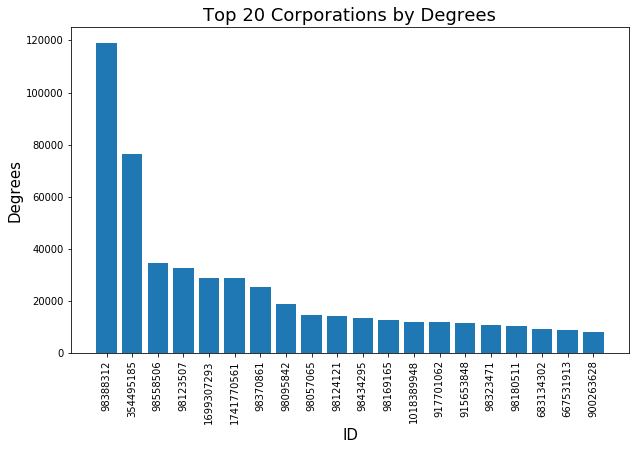

In [18]:
plt.figure(figsize=(10,6))
plt.bar('id','degree',data=degrees_plot)
plt.xlabel("ID", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degrees", size=15)
plt.title("Top 20 Corporations by Degrees", size=18)

In [19]:
g.inDegrees.sort("inDegree", ascending=False).show()

+----------+--------+
|        id|inDegree|
+----------+--------+
|  98388312|   93033|
|  98370861|   18203|
|  98558506|   17429|
|1699307293|   14479|
|1741770561|   14359|
|  98124121|   13540|
|  98169165|   12091|
| 917701062|   10844|
|1018389948|    6888|
| 667531913|    5804|
|  98195963|    5586|
|  98409330|    5423|
|  98502864|    4623|
|  98324027|    3594|
|  98362674|    3564|
|  98331781|    3286|
|  98185110|    3257|
|  98477766|    3061|
|  98410772|    3023|
|  98190062|    2817|
+----------+--------+
only showing top 20 rows



In [20]:
degrees_plot = g.inDegrees.sort("inDegree", ascending=False).toPandas()
degrees_plot['id'] = degrees_plot['id'].astype(str)
degrees_plot = degrees_plot[:20]
degrees_plot.head()

,id,inDegree
0,98388312,93033
1,98370861,18203
2,98558506,17429
3,1699307293,14479
4,1741770561,14359


Text(0.5, 1.0, 'Top 20 Corporations by inDegrees')

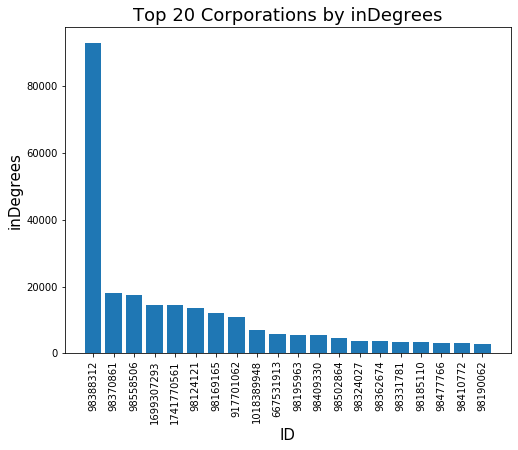

In [21]:
plt.figure(figsize=(8,6))
plt.bar('id','inDegree',data=degrees_plot)
plt.xlabel("ID", size=15)
plt.xticks(rotation=90)
plt.ylabel("inDegrees", size=15)
plt.title("Top 20 Corporations by inDegrees", size=18)

In [22]:
g.outDegrees.sort("outDegree", ascending=False).show()

+----------+---------+
|        id|outDegree|
+----------+---------+
| 354495185|    75358|
|  98123507|    32296|
|  98388312|    26087|
|  98095842|    18958|
|  98558506|    17076|
|1741770561|    14387|
|1699307293|    14300|
|  98057065|    14165|
|  98434295|    13285|
| 915653848|    11661|
|  98323471|    10954|
|  98180511|    10153|
| 683134302|     9008|
| 900263628|     8005|
|  98514793|     7397|
|  98370861|     7135|
|  98468321|     6469|
| 712577137|     6108|
|  98282638|     6019|
|  98002393|     5356|
+----------+---------+
only showing top 20 rows



In [23]:
degrees_plot = g.outDegrees.sort("outDegree", ascending=False).toPandas()
degrees_plot['id'] = degrees_plot['id'].astype(str)
degrees_plot = degrees_plot[:20]
degrees_plot.head()

,id,outDegree
0,354495185,75358
1,98123507,32296
2,98388312,26087
3,98095842,18958
4,98558506,17076


Text(0.5, 1.0, 'Top 20 Corporations by outDegrees')

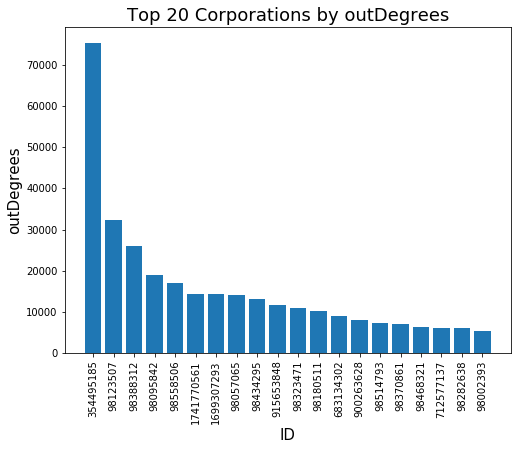

In [24]:
plt.figure(figsize=(8,6))
plt.bar('id','outDegree',data=degrees_plot)
plt.xlabel("ID", size=15)
plt.xticks(rotation=90)
plt.ylabel("outDegrees", size=15)
plt.title("Top 20 Corporations by outDegrees", size=18)

### Analysis of Specific Edges

Highest number of edges: 98388312

In [25]:
id_viz = edges.filter("src = 98388312 or dst = 98388312").groupby(edges.src,edges.dst).count()

In [26]:
id_viz.sort("count", ascending=False).show(5)

+---------+--------+-----+
|      src|     dst|count|
+---------+--------+-----+
| 98123507|98388312| 4210|
| 98370861|98388312| 4125|
| 98388312|98370861| 2910|
|354495185|98388312| 2746|
| 98057065|98388312| 2714|
+---------+--------+-----+
only showing top 5 rows



In [27]:
id_viz = id_viz.sort("count", ascending=False).toPandas()
id_viz.head()

,src,dst,count
0,98123507,98388312,4210
1,98370861,98388312,4125
2,98388312,98370861,2910
3,354495185,98388312,2746
4,98057065,98388312,2714


In [28]:
id_viz.count()

src      2025
dst      2025
count    2025
dtype: int64

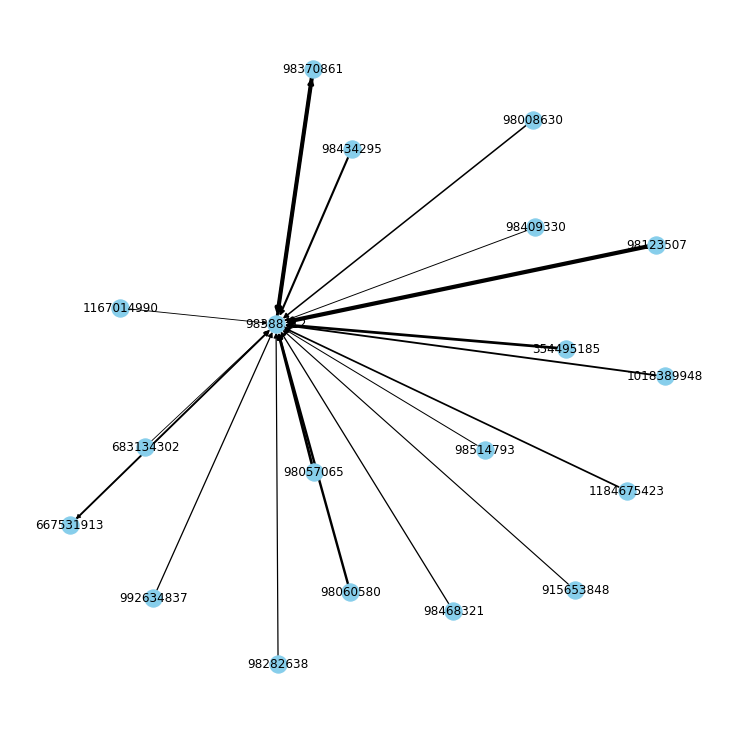

In [29]:
plotGraph(id_viz[:20], 1000)

In [30]:
id_viz = edges.filter("src = 354495185 or dst = 354495185").groupby(edges.src,edges.dst).count()

In [31]:
id_viz.sort("count", ascending=False).show(5)

+---------+---------+-----+
|      src|      dst|count|
+---------+---------+-----+
|354495185| 98388312| 2746|
|354495185| 98124121| 2262|
|354495185|917701062| 1590|
|354495185| 98169165| 1363|
|354495185| 98372649|  710|
+---------+---------+-----+
only showing top 5 rows



In [32]:
id_viz = id_viz.sort("count", ascending=False).toPandas()
id_viz.head()

,src,dst,count
0,354495185,98388312,2746
1,354495185,98124121,2262
2,354495185,917701062,1590
3,354495185,98169165,1363
4,354495185,98372649,710


In [33]:
id_viz.count()

src      7158
dst      7158
count    7158
dtype: int64

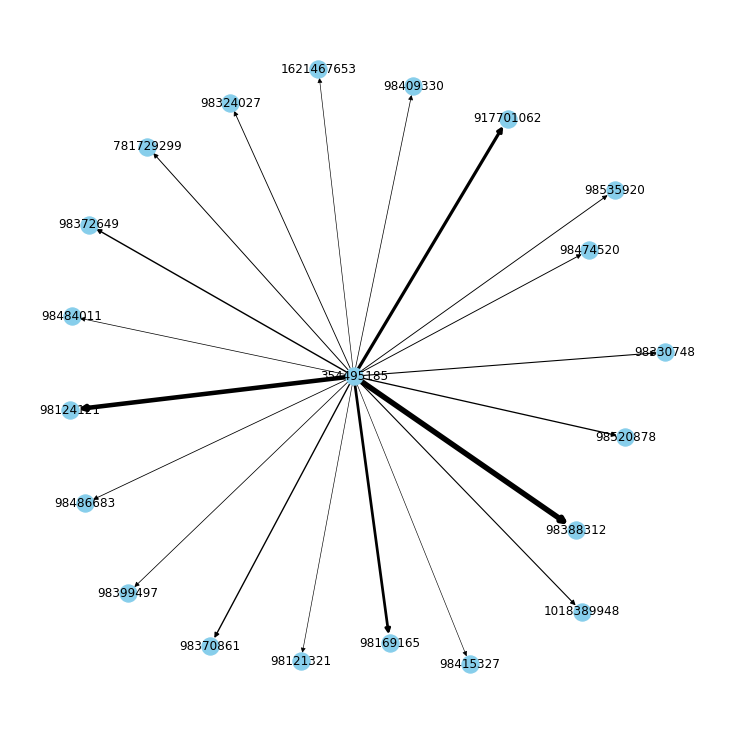

In [34]:
plotGraph(id_viz[:20], 500)

#### Connected Components

In [39]:
sc = spark.sparkContext
sc.setCheckpointDir('hdfs:///graphframes_cps/')
ccomp = g.connectedComponents()

In [49]:
ccomp.show()

+----------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+---------+
|        id|       type|tot_battles|num_wins|num_losses|win_perc|loss_perc|tot_damage_done|tot_damage_taken|damage_ratio|damage_done_per_win|damage_taken_per_loss|net_damage_per_battle|component|
+----------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+---------+
|  98478908|Corporation|        256|     172|        84|  0.6719|   0.3281|         233373|         1082057|      0.2157|          1356.8198|            12881.631|           -3315.1719| 98000007|
|  98470377|Corporation|        256|     255|         1|  0.9961|   0.0039|         573136|           28980|     19.7769|          2247.5922|              28980.0|            2125.6094| 98000007|
|  98492066|Corporat

In [51]:
ccomp = ccomp.select("component").groupby("component").count().sort("count", ascending=False)

In [54]:
ccomp.count()

835

In [52]:
ccomp.show()

+---------+-----+
|component|count|
+---------+-----+
| 98000007|30865|
| 98053180|   10|
| 98260355|    9|
| 98419918|    8|
| 98117666|    7|
| 98474089|    7|
| 98095730|    7|
| 98400081|    6|
| 98106202|    5|
| 98034589|    5|
| 98048402|    5|
| 98195622|    5|
| 98046910|    5|
| 98192338|    5|
| 98325853|    5|
| 98199971|    5|
| 98020144|    5|
| 98135902|    5|
| 98106302|    5|
| 98415399|    5|
+---------+-----+
only showing top 20 rows



In [56]:
ccomp_plot = ccomp.toPandas()
ccomp_plot['component'] = ccomp_plot['component'].astype(str)
ccomp_plot = ccomp_plot[:20]
ccomp_plot.head()

,component,count
0,98000007,30865
1,98053180,10
2,98260355,9
3,98419918,8
4,98095730,7


Text(0.5, 1.0, 'Top 20 Connected Components by Count')

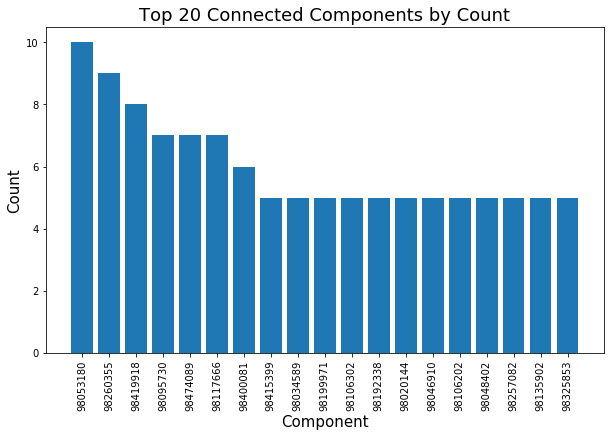

In [60]:
plt.figure(figsize=(10,6))
plt.bar('component','count',data=ccomp_plot[1:])
plt.xlabel("Component", size=15)
plt.xticks(rotation=90)
plt.ylabel("Count", size=15)
plt.title("Top 20 Connected Components by Count", size=18)

#### Page Rank

In [61]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)## look at the pagerank score for every vertex
pr.vertices.show()

## look at the weight of every edge
pr.edges.show()

+---------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+------------------+
|       id|       type|tot_battles|num_wins|num_losses|win_perc|loss_perc|tot_damage_done|tot_damage_taken|damage_ratio|damage_done_per_win|damage_taken_per_loss|net_damage_per_battle|          pagerank|
+---------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+------------------+
| 98443233|Corporation|          1|       1|         0|     1.0|      0.0|           3769|               0|        null|             3769.0|                 null|               3769.0| 0.548045039886302|
| 98539133|Corporation|          2|       0|         2|     0.0|      1.0|              0|        11871639|         0.0|               null|            5935819.5|           -5935819.5|

In [71]:
top_pr = pr.vertices.filter("tot_battles >= 100").sort("pagerank", ascending=False). \
select("id", "tot_battles", "win_perc", "pagerank")

top_pr.show()

+----------+-----------+--------+------------------+
|        id|tot_battles|win_perc|          pagerank|
+----------+-----------+--------+------------------+
|  98388312|     119120|   0.219|1196.6189962691108|
|  98558506|      34505|  0.4949| 320.0165441107117|
|  98370861|      25338|  0.2816|243.18873556917436|
|  98124121|      14334|  0.0554|132.87060595342533|
|1018389948|      12106|   0.431| 82.35562179277878|
| 667531913|       9059|  0.3593| 81.26649064570621|
|1741770561|      28746|  0.5005|  76.9338276874804|
|1699307293|      28779|  0.4969| 75.66383971380687|
| 354495185|      76345|  0.9871| 72.19561695312262|
|  98409330|       7337|  0.2609| 65.19514015108312|
|  98477766|       7458|  0.5896|61.289031746036976|
|  98495482|       2944|  0.7565| 56.06022826319053|
| 917701062|      11916|    0.09|52.878921358710265|
|  98169165|      12789|  0.0546| 51.12717444255027|
|  98502864|       5387|  0.1418| 50.19078921770766|
|  98362674|       5209|  0.3158| 47.118689567

In [74]:
pr.vertices.filter("tot_battles >= 100").sort("pagerank", ascending=True). \
select("id", "tot_battles", "win_perc", "pagerank").show()

+---------+-----------+--------+-----------------+
|       id|tot_battles|win_perc|         pagerank|
+---------+-----------+--------+-----------------+
| 98398949|        451|     1.0|0.548045039886302|
| 98442723|        382|     1.0|0.548045039886302|
| 98008623|        121|     1.0|0.548045039886302|
| 98316286|        207|     1.0|0.548045039886302|
| 98329794|        349|     1.0|0.548045039886302|
| 98465252|        108|     1.0|0.548045039886302|
| 98535046|        396|     1.0|0.548045039886302|
| 98334118|        129|     1.0|0.548045039886302|
| 98499294|        110|     1.0|0.548045039886302|
|956307834|        121|     1.0|0.548045039886302|
| 98566103|        118|     1.0|0.548045039886302|
|393938977|        109|     1.0|0.548045039886302|
| 98494858|        540|     1.0|0.548045039886302|
| 98355879|        110|     1.0|0.548045039886302|
| 98555005|        104|     1.0|0.548045039886302|
| 98477844|        144|     1.0|0.548045039886302|
|484525146|        213|     1.0

In [73]:
top_pr_pan = top_pr.toPandas()

top_pr_pan.head(10)

,id,tot_battles,win_perc,pagerank
0,98388312,119120,0.2190,1196.618996
1,98558506,34505,0.4949,320.016544
2,98370861,25338,0.2816,243.188736
3,98124121,14334,0.0554,132.870606
4,1018389948,12106,0.4310,82.355622
5,667531913,9059,0.3593,81.266491
6,1741770561,28746,0.5005,76.933828
7,1699307293,28779,0.4969,75.663840
8,354495185,76345,0.9871,72.195617
9,98409330,7337,0.2609,65.195140


In [75]:
result = g.labelPropagation(maxIter=5)

In [76]:
result.show()

+---------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+---------+
|       id|       type|tot_battles|num_wins|num_losses|win_perc|loss_perc|tot_damage_done|tot_damage_taken|damage_ratio|damage_done_per_win|damage_taken_per_loss|net_damage_per_battle|    label|
+---------+-----------+-----------+--------+----------+--------+---------+---------------+----------------+------------+-------------------+---------------------+---------------------+---------+
| 98443233|Corporation|          1|       1|         0|     1.0|      0.0|           3769|               0|        null|             3769.0|                 null|               3769.0| 98415748|
| 98539133|Corporation|          2|       0|         2|     0.0|      1.0|              0|        11871639|         0.0|               null|            5935819.5|           -5935819.5|354495185|
| 98538853|Corporation|  

In [77]:
labelp = result.select("label").groupby("label").count().sort("count", ascending=False)
labelp.show()

+---------+-----+
|    label|count|
+---------+-----+
|354495185|13039|
| 98388312| 5038|
| 98370861| 1216|
| 98140648|  356|
| 98508029|  189|
| 98134066|  165|
| 98345443|  128|
| 98371340|  116|
| 98507981|  108|
| 98367271|  100|
| 98342370|   92|
| 98380939|   85|
| 98528427|   85|
| 98463585|   85|
| 98398949|   81|
| 98123507|   81|
| 98235358|   80|
| 98442723|   76|
| 98438640|   75|
| 98461984|   74|
+---------+-----+
only showing top 20 rows



In [78]:
labelp.count()

4676

In [79]:
labelp_plot = labelp.toPandas()
labelp_plot['label'] = labelp_plot['label'].astype(str)
labelp_plot = labelp_plot[:20]
labelp_plot.head()

,label,count
0,354495185,13039
1,98388312,5038
2,98370861,1216
3,98140648,356
4,98508029,189


Text(0.5, 1.0, 'Top 20 Communities by Size')

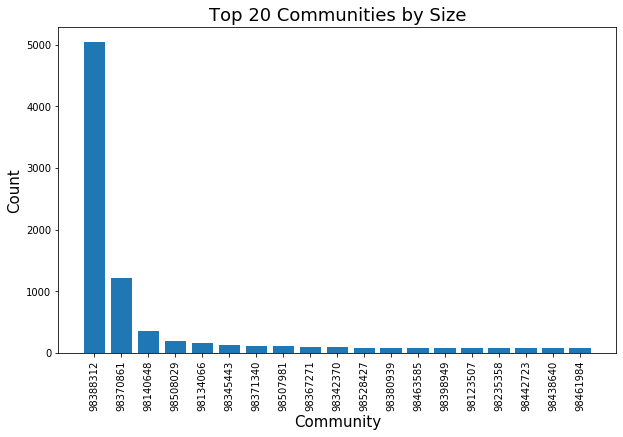

In [81]:
plt.figure(figsize=(10,6))
plt.bar('label','count',data=labelp_plot[1:])
plt.xlabel("Community", size=15)
plt.xticks(rotation=90)
plt.ylabel("Count", size=15)
plt.title("Top 20 Communities by Size", size=18)